In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("../dataset/INMET_GROUP_DATA.CSV", delimiter=";", decimal=",")
df = df[(df["Temp bulbo seco media"] > -10) & (df["Temp bulbo seco media"] < 40)]

In [3]:
# Append season to table
conditions = [
    (df['Mês'] == 12) & (df["Dia"] > 21),
    (df['Mês'] >= 1) & (df["Mês"] < 3),
    (df['Mês'] == 3) & (df["Dia"] <= 21),
    (df['Mês'] == 3) & (df["Dia"] > 21),
    (df['Mês'] >= 3) & (df["Mês"] < 6),
    (df['Mês'] == 6) & (df["Dia"] <= 21),
    (df['Mês'] == 6) & (df["Dia"] > 21),
    (df['Mês'] >= 7) & (df["Mês"] < 9),
    (df['Mês'] == 9) & (df["Dia"] <= 23),
    (df['Mês'] == 9) & (df["Dia"] > 23),
    (df['Mês'] >= 10) & (df["Mês"] < 12),
    (df['Mês'] == 12) & (df["Dia"] <= 21),
]

values = [
    "verao",
    "verao",
    "verao",
    "outono",
    "outono",
    "outono",
    "inverno",
    "inverno",
    "inverno",
    "primavera",
    "primavera",
    "primavera",
]

df["season"] = np.select(conditions, values)

# Vetor de estacoes e medidores com dados (>5 anos de coleta)
seasons = ["inverno", "outono", "primavera", "verao"]
regioes = {"N": "Norte", "SE": "Sudeste", "CO": "Centro Oeste", "NE": "Nordeste", "S": "Sul"}
medidores_inicial = df["Estacao"].unique()
medidores = []
i = 1
for medidor in medidores_inicial:
    print(f"{medidor} - {i}/{len(medidores_inicial)}", end="\r")
    i += 1
    ult_ano = df[df["Estacao"] == medidor]["Ano"].max()
    pri_ano = df[df["Estacao"] == medidor]["Ano"].min()
    if (ult_ano - pri_ano) > 5:
        medidores.append(medidor)    

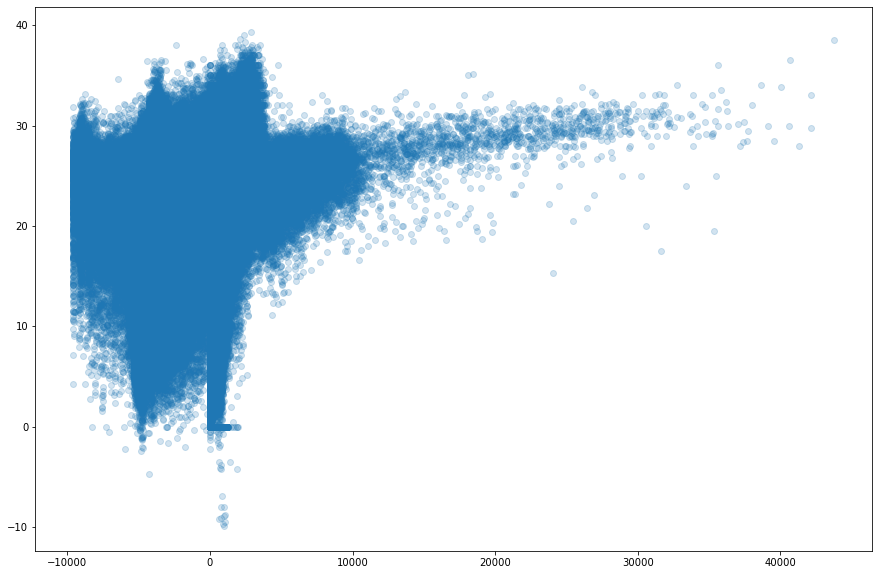

In [4]:
# Correlacionar radiacao com temperatura
df_rad = df[df["Radiacao media"] != -9999]
X = df_rad[["Radiacao media"]]
y = df_rad[["Temp bulbo seco media"]]

fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X, y, alpha=0.20)

In [9]:
# Preparar para regressao
def remove_outliers(data, q1 = 0.25, q3 = 0.75):
    Q1 = data["Temp bulbo seco media"].quantile(q1)
    Q3 = data["Temp bulbo seco media"].quantile(q3)
    data = data[(data["Temp bulbo seco media"] >= Q1) & (data["Temp bulbo seco media"] <= Q3)]
    return data

def get_monthly_mean(data, columns = "Temp bulbo seco media"):
    # Reduce number of elements by grouping in months
    return data.groupby(["Ano", "Mês"])[columns].mean().reset_index()

# Regressao linear do scikit learn
def regress(medidor, estacao, monthly = True):
    # Calculate coefficient and interception for regression line
    data = df[(df["Estacao"] == medidor) & (df["season"] == estacao)]
    data = remove_outliers(data)
    if monthly:
         data = get_monthly_mean(data)
    X = data[["Ano"]]
    y = data[["Temp bulbo seco media"]]
    if (len(X) == 0) or (len(y) == 0):
        return np.inf, np.inf
    reg = LinearRegression().fit(X, y)
    a = round(reg.coef_[0][0], 5)
    b = round(reg.intercept_[0], 5)
    r2 = reg.score(X, y)
    return a, b, r2

# Avaliar R2

In [6]:
# Remove all values that are outstanding
df = df[df["Temp bulbo seco media"] != -9999]

In [7]:
# Runs for each station for each season finding the slope and intercept     
def run_all(monthly = False):
    coefs = {}
    angular_coefs = {}
    interc_coefs = {}
    r2_values = {}
    for season in seasons:
        angular_coefs[season] = []
        interc_coefs[season] = []
        r2_values[season] = []
    i = 1
    for medidor in medidores:
        print(f"{medidor} - {i}/{len(medidores)}", end="\r")
        values = []
        for season in seasons:
            coef, interc, r2 = regress(medidor, season, monthly)
            if coef == np.inf:
                values.append((np.inf, np.inf))
            values.append((coef, interc, r2))
            angular_coefs[season].append(coef)
            interc_coefs[season].append(interc)
            r2_values[season].append(r2)
        coefs[medidor] = values
        i += 1

    return coefs, angular_coefs, interc_coefs, r2_values

In [10]:
coefs_monthly, angular_coefs, interc_coefs, r2_values = run_all()

In [13]:
def plot_reg_seasons(medidor, coefs):
    # Plots 4 graphs if possible one for each regression
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
    i, j = (0, 0)
    for estacao in seasons:
        data = df[(df["Estacao"] == medidor) & (df["season"] == estacao)]
        data = get_monthly_mean(data)
        years = data["Ano"].unique()
        
        data = remove_outliers(data)
        X = data[["Ano"]]
        y = data[["Temp bulbo seco media"]]
        axs[i][j].scatter(X, y)
        
        coef, interc, r2 = coefs[medidor][seasons.index(estacao)]
        y_p = (years * coef) + interc
        axs[i][j].plot(years, y_p, color="r")
        axs[i][j].set_title(f"{medidor} Temperatura media anual - {estacao}")
        axs[i][j].set_ylabel(f"Temperatura C°")
        axs[i][j].set_xlabel(f"Ano")
        min_temp = y["Temp bulbo seco media"].min()-2
        max_temp = y["Temp bulbo seco media"].max()+2
        axs[i][j].set_ylim([min_temp, max_temp])
        i += 1
        if i == 2:
            i = 0
            j = 1
    plt.show()

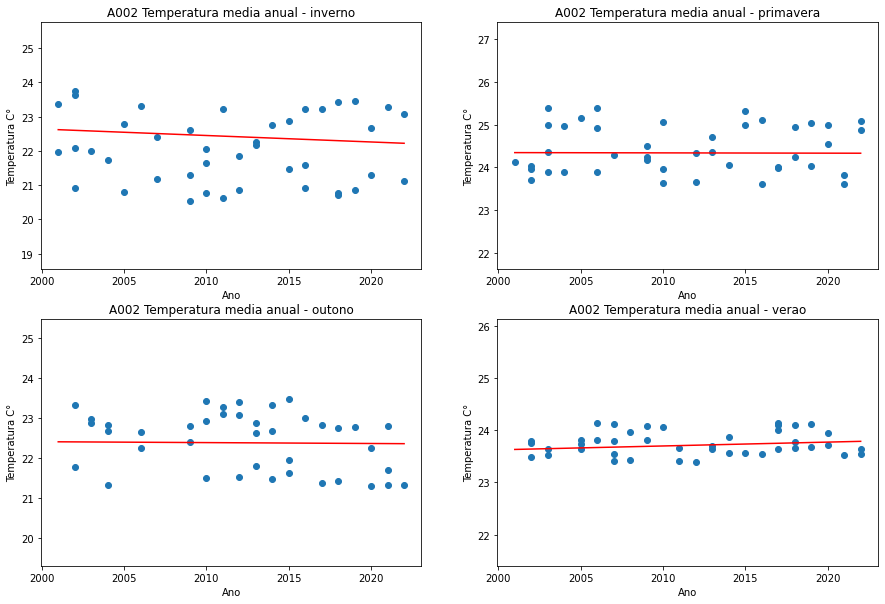

In [14]:
plot_reg_seasons(medidores[5], coefs_monthly)

In [15]:
def clean_coefs(coefs, q1_perc = 0.05, q3_perc = 0.95):
    n_coefs = {}
    
    for season in seasons:
        # Intervalo 5%-95% -> removendo 10% dos valores extremos
        Q1 = np.quantile(coefs[season], q1_perc)
        Q3 = np.quantile(coefs[season], q3_perc)
        
        n_coefs[season] = [val for val in coefs[season] if (val <= Q3) and (val >= Q1)]
    return n_coefs

In [16]:
clean_angular = clean_coefs(angular_coefs)
clean_interc = clean_coefs(interc_coefs)
clean_r2 = clean_coefs(r2_values)

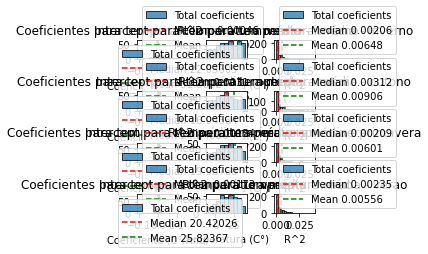

In [35]:
# Distribution of coefficients along the stations for all of Brazil
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(3, 3))
n_bins = np.linspace(-0.1, 0.1, 50)
i = 0
j = 0
for season in seasons:
    med = np.median(clean_angular[season])
    mea = np.mean(clean_angular[season])
    axs[i][j].hist(clean_angular[season], bins=n_bins, histtype="bar", ec="black", alpha=0.75, label="Total coeficients")
    axs[i][j].axvline(med, color="r", linestyle="dashed", label=f"Median {round(med, 5)}")
    axs[i][j].axvline(mea, color="g", linestyle="dashed", label=f"Mean {round(mea, 5)}")
    axs[i][j].set_title(f"Coeficientes para temperatura média - {season}")
    axs[i][j].set_xlabel("Coeficiente (C°/Ano)")
    axs[i][j].xaxis.set_tick_params(labelbottom=True)
    axs[i][j].legend()
    i += 1
i = 0
j = 1
n_bins = np.linspace(-10, 40, 10)
for season in seasons:
    med = np.median(clean_interc[season])
    mea = np.mean(clean_interc[season])
    axs[i][j].hist(clean_interc[season], bins=n_bins, histtype="bar", ec="black", alpha=0.75, label="Total coeficients")
    axs[i][j].axvline(med, color="r", linestyle="dashed", label=f"Median {round(med, 5)}")
    axs[i][j].axvline(mea, color="g", linestyle="dashed", label=f"Mean {round(mea, 5)}")
    axs[i][j].set_title(f"Intercept para temperatura média - {season}")
    axs[i][j].set_xlabel("Temperatura (C°)")
    axs[i][j].xaxis.set_tick_params(labelbottom=True)
    axs[i][j].legend()
    i += 1
i = 0
j = 2
m_val = 0
for season in seasons:
    m_val = min(min(clean_r2[season]), m_val)
n_bins = np.linspace(0, 0.04, 20)
for season in seasons:
    med = np.median(clean_r2[season])
    mea = np.mean(clean_r2[season])
    axs[i][j].hist(clean_r2[season], bins=n_bins, histtype="bar", ec="black", alpha=0.75, label="Total coeficients")
    axs[i][j].axvline(med, color="r", linestyle="dashed", label=f"Median {round(med, 5)}")
    axs[i][j].axvline(mea, color="g", linestyle="dashed", label=f"Mean {round(mea, 5)}")
    axs[i][j].set_title(f"R^2 para temperatura média - {season}")
    axs[i][j].set_xlabel("R^2")
    axs[i][j].xaxis.set_tick_params(labelbottom=True)
    axs[i][j].legend()
    i += 1
save = True
if save:
    plt.savefig("coefs_r2.png")

In [ ]:
# Separando para cada regiao do Brasil
df_stations = pd.read_csv("../dataset/STATION_DATA.CSV", delimiter=";", decimal=",")
df_stations

In [ ]:
# Group stations by region
regions = df_stations["REGIAO"].unique()
stations_region = {}
for region in regions:
    stations_region[region] = df_stations[df_stations["REGIAO"] == region]["CODIGO"]
    
def get_coeff(coefs, typ):
    values = {}
    for idx in range(4):
            values[seasons[idx]] = []
    for l in coefs:
        for idx in range(4):
            values[seasons[idx]].append(l[idx][typ])
    return values

def plot_region(uf, q1, q3):
    coefs_reg = []
    for medidor in stations_region[uf]:
        if medidor in coefs_monthly.keys():
            coefs_reg.append(coefs_monthly[medidor])
    slopes_reg = get_coeff(coefs_reg, 0)
    intercepts_reg = get_coeff(coefs_reg, 1)
    clean_reg = clean_coefs(slopes_reg, q1, q3)
    clean_inter_reg = clean_coefs(intercepts_reg, q1, q3)
    # Distribution of coefficients along the stations for all of the region
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
    min_bound = min(min(clean_reg["inverno"]), min(clean_reg["outono"]), min(clean_reg["verao"]), min(clean_reg["primavera"]))
    max_bound = max(max(clean_reg["inverno"]), max(clean_reg["outono"]), max(clean_reg["verao"]), max(clean_reg["primavera"]))
    n_bins = np.linspace(min_bound, max_bound, 20)
    i = 0
    j = 0
    for season in seasons:
        mea = np.median(clean_reg[season])
        axs[i][j].hist(clean_reg[season], bins=n_bins, histtype="bar", ec="black", alpha=0.75, label="Total coeficients")
        axs[i][j].axvline(mea, color="r", linestyle="dashed", label=f"Median {round(mea, 5)}")
        axs[i][j].set_title(f"Coeficientes para temperatura média - {regioes[uf]} - {season}")
        axs[i][j].set_xlabel("Coeficiente (C°/Ano)")
        axs[i][j].xaxis.set_tick_params(labelbottom=True)
        axs[i][j].legend()
        i += 1
    i = 0
    j = 1
    min_bound = min(min(clean_inter_reg["inverno"]), 
                    min(clean_inter_reg["outono"]), 
                    min(clean_inter_reg["verao"]), 
                    min(clean_inter_reg["primavera"]))
    n_bins = np.linspace(min_bound, 40, 20)
    for season in seasons:
        med = np.median(clean_inter_reg[season])
        axs[i][j].hist(clean_inter_reg[season], bins=n_bins, histtype="bar", ec="black", alpha=0.75, label="Total coeficients")
        axs[i][j].axvline(med, color="r", linestyle="dashed", label=f"Median {round(med, 5)}")
        axs[i][j].set_title(f"Intercept para temperatura média - {regioes[uf]} - {season}")
        axs[i][j].set_xlabel("Temperatura (C°)")
        axs[i][j].xaxis.set_tick_params(labelbottom=True)
        axs[i][j].legend()
        i += 1
    plt.show()
    return clean_reg

In [ ]:
# Norte
clean_norte = plot_region("N", 0.25, 0.9)

In [ ]:
# Nordeste
clean_norte = plot_region("NE", 0.15, 0.9)

In [ ]:
# Sudeste
clean_norte = plot_region("SE", 0.15, 0.9)

In [ ]:
# Centro Oeste
clean_norte = plot_region("CO", 0.15, 0.9)

In [ ]:
# Sul
clean_norte = plot_region("S", 0.15, 0.9)